Bevor Sie dieses Problem einreichen, stellen Sie sicher, dass alles wie erwartet läuft. Starten Sie zuerst **den Kernel neu** (wählen Sie in der Menüleiste Kernel$\rightarrow$Restart) und führen Sie dann **jede Zelle aus** (wählen Sie in der Menüleiste Cell$\rightarrow$Run Cells ausführen). Wenn Sie Fragen zum Jupyterhub oder zur Aufgabe haben, stehe ich Ihnen gerne zur Verfügung: quang.tran@fh-dortmund.de

Stellen Sie sicher, dass Sie alle Stellen ausfüllen, an denen "YOUR CODE HERE" oder "YOUR ANSWER HERE" steht, sowie Ihren Namen und Ihre Mitarbeiter unten:


In [ ]:
NAME = ""
Mitarbeiter = ""

---

<img src="fhlogo.png" width="350">

# Kartierung bei bekannten Posen (6.2 von Hertzberg et al.)

Bevor wir uns der allgemeinen Lösung des SLAM-Problems zuwenden, betrachten wir als Spezialfall Erstellen einer Karte unter der Bedingung, dass die Roboterposen genau bekannt sind (Localisierung schon bekannt). Dieses Tutorial zeigt, wie man LIDAR-Messungen (Entfernungsmessungen) aus einer Datei einliest und in ein Belegungsraster konvertiert.

## Teil A: Theoretisch Belegtheitskarte/Occupancy Grid Map (3 Punkte)
Bitte füllen Sie alle untenstehenden Antworten aus:

Frage 1

YOUR ANSWER HERE

Frage 2

YOUR ANSWER HERE

## Teil B: Algorithmus Belegtheitskarte/Occupancy Grid Map( points)

Belegtheitskarte [Hans Moravec, A.E. Elfes: High resolution maps from wide angle sonar, Proc. IEEE Int. Conf. Robotics Autom. (1985)] sind ein beliebter, probabilistischer Ansatz zur Darstellung der Umgebung. Das Gitter ist im Grunde eine diskrete Darstellung der Umgebung, die anzeigt, ob eine Gitterzelle besetzt ist oder nicht. Hier wird die Karte als Numpy-Array dargestellt, und Zahlen nahe bei 1 bedeuten, dass die Zelle besetzt ist (schwarz markiert), Zahlen nahe bei 0 bedeuten, dass sie frei ist (hellgrau markiert). Das Raster hat die Möglichkeit, unbekannte (unbeobachtete, schwarz markiert) ereiche darzustellen, die nahe bei 0,5 liegen.

Eingabe : Sequenz von LIDAR Messwerten $z_t$ und korrekten Posen $x_t$.

Ausgabe:  Belegtheitsw.keit Bel($m_{x,z}$) für jede Rasterzelle (x, z).


<img src="Original.PNG" width="350">

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, radians, pi
import lidar_to_grid_map as lg 

Sie erhalten eine Exel-Datei im selben Ordner, die die Laserbereichsmessung enthält. Die Messdatei enthält die Abstände und die dazugehörigen Winkel in einem csv-Format (comma separated values). Lassen Sie uns die Methode file_read schreiben:

In [2]:
def file_read(f):
    """
    Reading LIDAR laser beams (angles and corresponding distance data)
    """
    measures = [line.split(",") for line in open(f)]
    angles = []
    distances = []
    for measure in measures:
        angles.append(float(measure[0]))
        distances.append(float(measure[1]))
    angles = np.array(angles)
    distances = np.array(distances)
    return angles, distances

Aus den Abständen und den Winkeln lassen sich leicht die x- und y-Koordinaten mit sin und cos bestimmen. Für die Darstellung wird matplotlib.pyplot (plt) verwendet.

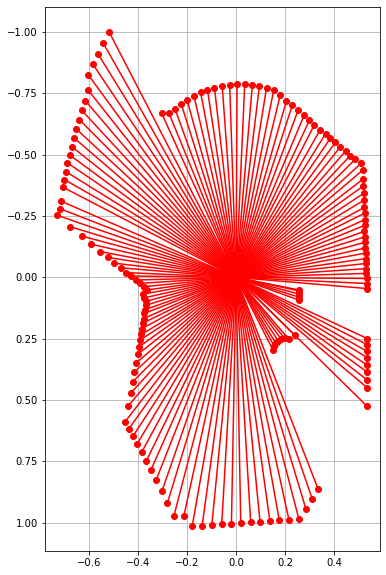

In [3]:
ang, dist = file_read("lidar_datei.csv")
ox = np.sin(ang) * dist
oy = np.cos(ang) * dist
plt.figure(figsize=(6,10))
plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-") # lines from 0,0 to the measurements

plt.axis("equal")
bottom, top = plt.ylim()  # return the current ylim
plt.ylim((top, bottom)) # rescale y axis, to match the grid orientation
plt.grid(True)

plt.show()

Die Datei lidar_to_grid_map.py enthält praktische Funktionen, mit denen eine 2D-Entfernungsmessung in eine Rasterkarte umgewandelt werden kann. Zum Beispiel gibt die bresenham die eine gerade Linie zwischen zwei Punkten in eine Rasterkarte. Schauen wir uns an, wie das funktioniert:

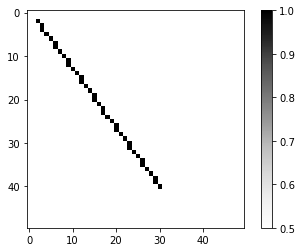

In [4]:
def bresenham(start, end):
    """
    Implementation of Bresenham's line drawing algorithm
    See en.wikipedia.org/wiki/Bresenham's_line_algorithm
    Bresenham's Line Algorithm
    Produces a np.array from start and end (original from roguebasin.com)
    >>> points1 = bresenham((4, 4), (6, 10))
    >>> print(points1)
    np.array([[4,4], [4,5], [5,6], [5,7], [5,8], [6,9], [6,10]])
    """
    # setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
    is_steep = abs(dy) > abs(dx)  # determine how steep the line is
    if is_steep:  # rotate line
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    # swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
    dx = x2 - x1  # recalculate differentials
    dy = y2 - y1  # recalculate differentials
    error = int(dx / 2.0)  # calculate error
    y_step = 1 if y1 < y2 else -1
    # iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = [y, x] if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += y_step
            error += dx
    if swapped:  # reverse the list if the coordinates were swapped
        points.reverse()
    points = np.array(points)
    return points

map1 = np.ones((50, 50)) * 0.5
line = bresenham((2, 2), (40, 30))

for l in line:
    map1[l[0]][l[1]] = 1
    
plt.imshow(map1, cmap = 'Greys') 
plt.colorbar()
plt.show()

 Wir verwenden die Hilfsfunktion aus der Datei lidar_to_grid_map.py, nämlich: calc_grid_map_config(), um den Kartenparameter zu erstellen. Lassen Sie uns diese Bresenham auf reale Daten anwenden:

In [5]:
def generate_ray_casting_grid_map(ox, oy, xy_resolution):
    """
    Kartieren-Funktion
    """
    #Verwenden der Funktion calc_grid_map_config() zum Erstellen einer Grid Map
    min_x, min_y, max_x, max_y, x_w, y_w = lg.calc_grid_map_config(ox, oy, xy_resolution)
    
    #Initialisieren der Grid Map mit 0,5 logodd
    occupancy_map = np.ones((x_w, y_w)) / 2 
    
    #Berechnen der Mittelpunktskoordinate der Karte
    center_x = int(round(-min_x / xy_resolution))  # Zentrum x-Koordinate der Rasterkarte
    center_y = int(round(-min_y / xy_resolution))  # Zentrum y-Koordinate der Rasterkarte
    
 
    """
    blendet diesen Block in der Realease-Version aus
    Aufgabe:
        Aktualisieren der Belegtheitskarte mit inversem Sensormodell und  Bresenham ray-casting
    Hinweis: 
        Verwenden Sie bresenham(), um den Strahl von der Mittelpunktskoordinate nach (ix,iy) zu berechnen
        Aktualisieren der Numpy-Matrix occupancy_map
    Ergebnis: 
        occupancy_map: aktualisierte Karte m 
    """   
    for (x, y) in zip(ox, oy):
        # x coordinate of the the occupied area
        ix = int(round((x - min_x) / xy_resolution))
        # y coordinate of the the occupied area
        iy = int(round((y - min_y) / xy_resolution))
        
    # SOLUTION
        laser_beams = bresenham((center_x, center_y), (ix, iy))  # line form the lidar to the occupied point
        for laser_beam in laser_beams:
            occupancy_map[laser_beam[0]][laser_beam[1]] = 0.0  # free area 0.0
            
        occupancy_map[ix][iy] = 1.0  # occupied area 1.0
        occupancy_map[ix + 1][iy] = 1.0  # extend the occupied area
        occupancy_map[ix][iy + 1] = 1.0  # extend the occupied area           
        occupancy_map[ix + 1][iy + 1] = 1.0  # extend the occupied area
    #  SOLUTION
    
    return occupancy_map, min_x, max_x, min_y, max_y, xy_resolution
    


In [6]:
xyreso = 0.02  # x-y grid resolution
yawreso = math.radians(3.1)  # yaw angle resolution [rad]
ang, dist = file_read("lidar_datei.csv")
ox = np.sin(ang) * dist
oy = np.cos(ang) * dist
pmap, minx, maxx, miny, maxy, xyreso = generate_ray_casting_grid_map(ox, oy, xyreso)
xyres = np.array(pmap).shape

Die Größe der Belegtheitskarte ist  150 x 100 .


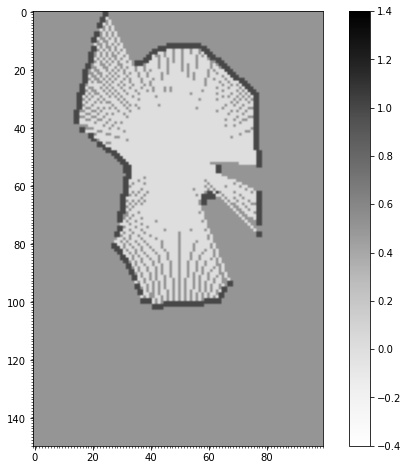

In [7]:

plt.figure(figsize=(20,8))
plt.subplot(122)
plt.imshow(pmap, cmap = 'Greys') 
plt.clim(-0.4, 1.4)
plt.gca().set_xticks(np.arange(-.5, xyres[1], 1), minor = True)
plt.gca().set_yticks(np.arange(-.5, xyres[0], 1), minor = True)
#plt.grid(True, which="minor", color="w", linewidth = .6, alpha = 0.5)
plt.colorbar() 
plt.show()

Gratulation, Sie haben gerade eine Belegtheitskarte vom Laserscanner erstellt 